# Optotagged waveforms
pull waveforms form kilosort files and compare between different optotagged units


In [1]:
import pathlib as pl
from configparser import ConfigParser

import joblib as jl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from IPython.display import display
from scipy import interpolate
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture

import nems.db as nd
import nems_lbhb.baphy_io as io
from src.root_path import config_path

[nems.configs.defaults INFO] Saving log messages to /tmp/nems/NEMS 2021-11-11 182953.log
/auto/users/mateo/nems_db/nems_lbhb/SettingXML.py:66: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  {K: SubEl.get(K) for K in SubEl.keys() if K is not 'name'}
/auto/users/mateo/nems_db/nems_lbhb/SettingXML.py:76: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  {K: SubEl.get(K) for K in SubEl.keys() if K is not 'name'}
/auto/users/mateo/nems_db/nems_lbhb/SettingXML.py:81: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  {K: SubEl.get(K) for K in SubEl.keys() if K is not 'name'}


#### Loads FTC data
right now form a single file
to do, load based on DF querries for neruons

In [2]:
# plt.style.use(['dark_background', config_path / 'notebook.mplstyle'])
# plt.style.use(['default', config_path / 'notebook.mplstyle'])

config = ConfigParser()
config.read_file(open(config_path / 'settings.ini'))

In [3]:

runclass = 'FTC' # gRunClass.name='{runclass}' AND
sql = "SELECT sCellFile.*,gSingleCell.siteid,gSingleCell.phototag FROM gSingleCell " +\
      "INNER JOIN sCellFile ON gSingleCell.id=sCellFile.singleid " +\
      "INNER JOIN gRunClass on gRunClass.id=sCellFile.runclassid " +\
      f"WHERE not(isnull(phototag))"
d = nd.pd_query(sql)
d['parmfile'] = d['stimpath'] + d['stimfile']
d['animal'] = d['stimpath'].apply(lambda x: x.split('/')[-3])

# for cellid in d.cellid.unique():
#     isolation = nd.get_cell_files(cellid).loc[:,'isolation'].unique()
#     if len(isolation) !=1:
#         print(f'{cellid}, isol {isolation}')
# print('done')

[numexpr.utils INFO] NumExpr defaulting to 8 threads.


#### select sites and parameter files, and parses optotagging values

In [4]:
ff_tag = d.phototag.isin(['a', 's'])
tag_df = d.loc[ff_tag, ['cellid', 'phototag', 'animal']].drop_duplicates()
display(tag_df)
# display(tag_df.loc[tag_df.cellid == 'TNC016a-51-6',:])

,cellid,phototag,animal
0,TNC018a-16-4,s,Teonancatl
2,TNC018a-58-2,a,Teonancatl
3,TNC018a-03-2,s,Teonancatl
4,TNC018a-04-2,s,Teonancatl
5,TNC018a-05-3,s,Teonancatl
...,...,...,...
7459,TNC019a-57-1,s,Teonancatl
7460,TNC019a-57-2,a,Teonancatl
7461,TNC019a-57-3,s,Teonancatl
7462,TNC019a-58-1,s,Teonancatl


#### loads recordins, gets tuning curves, organizes in big array


In [5]:
def get_waveform_metrics(mwf):
    """
    powered by Charlie: Calculates spike width in ms (sw), peak-through ratio (ptr), full width half max in ms (fwhm), end slope (es)
    time to base line in ms (bs) and trough in index, all over a smoothed and normazlized waveform (wf)
    :param mwf: 1d array of waveform,
    :return: sw, prt, fwhm, bs, trough, wf
    """
    fit2 = interpolate.UnivariateSpline(np.arange(len(mwf)), mwf)
    mwf = fit2(np.linspace(0, len(mwf), 10000))
    mwf /= abs(mwf.min())
    wf = mwf

    if mwf[np.argmax(np.abs(mwf))] > 0:
        sw = ptr = fwhm = es = bs = trough = np.nan

    else:
        fs = 10000 / (82 / 30000)
        valley = np.argmin(mwf)
        peak = np.argmax(mwf[valley:]) + valley
        trough = valley

        # force 0 to be the mean of the positive waveform preceding the valley
        mi = np.argmax(mwf[:valley])
        baseline = np.mean(mwf[:mi])
        mwf -= baseline

        sw = (peak - valley) / fs * 1000  # ms

        # get fwhm (of valley)
        left = np.argmin(np.abs(mwf[:valley] - (mwf[valley] / 2)))
        right = np.argmin(np.abs(mwf[valley:] - (mwf[valley] / 2))) + valley
        fwhm = (right - left) / fs * 1000

        if mwf[peak] <= 0:
            ptr = 0
        else:
            ptr = abs(mwf[peak]) / abs(mwf[valley])

        #0.5 ms ~ 1800 bins
        #es.append((((mwf[valley + 850] - mwf[valley + 650])*fs) / (200 * fs)))
        #es.append((mwf[valley + 950] - mwf[valley + 900]) / 50)
        #es.append((mwf[valley + 1800] - mwf[valley + 1750]) / 50)
        #es.append((mwf[valley + 780] - mwf[valley + 750]))
        #es.append((mwf[valley + 2200] - mwf[valley + 900]))
        es = (mwf[valley + 550] - mwf[valley + 350])
        # save time waveform returns to baseline
        bs = np.argmin(np.abs(mwf[peak:])) / fs * 1000

    return sw, ptr, fwhm, es, bs, trough, wf


def cluster_by_metrics(DF):
    """
    takes dataframe of waveform metrics, and returns a copy of the DF with a cluster label column,
    :param DF:
    :return:
    """

    toclust = DF.dropna(axis=0).copy()
    csw = toclust['sw'].values  #csw -= csw.mean(); csw /= csw.std(); csw*=10
    cptr = toclust['ptr'].values  #cptr -= cptr.mean(); cptr /= cptr.std()
    ces = toclust['es'].values
    # wf = toclust['waveform_norm'].values
    # trough = toclust['trough'].values

    X = np.stack((csw, cptr, ces), axis=1)
    # kmeans = KMeans(n_clusters=2, random_state=0).fit(X)
    gmm = GaussianMixture(n_components=2).fit(X)
    labels = gmm.predict(X)

    named_labels = np.empty(len(labels), dtype=object)
    if csw[labels == 1].mean() < csw[labels == 0].mean():
        named_labels[labels == 1] = 'narrow'
        named_labels[labels == 0] = 'broad'
    else:
        named_labels[labels == 0] = 'narrow'
        named_labels[labels == 1] = 'broad'

    toclust['spike_type'] = named_labels

    merge = pd.merge(DF, toclust.loc[:, ('cellid', 'spike_type')], how='left', on='cellid', validate='1:1')

    return merge


# eg_waveform = io.get_mean_spike_waveform('TNC017a-09-1', 'Teonancatl', usespkfile=True)
# sw, ptr, fwhm, es, bs, trough, wf = get_waveform_metrics(eg_waveform)
# print(sw, ptr, fwhm, es, bs, trough)

In [6]:
print('loading all waveforms into dataframe ...')

df_file = pl.Path(config['paths']['analysis_cache']) / '211028_classified_waveform_summary_df'
recache = False

if df_file.exists() and recache == False:
    print(f'DF file found\nloading from {df_file}')
    wf_summary_df = jl.load(df_file)
else:
    print('calculating waveform parameters...')
    wf_summary_df = pd.DataFrame()
    for _, row in tag_df.iterrows():
        mean_waveform = io.get_mean_spike_waveform(row.cellid, row.animal, usespkfile=True)
        isolation = nd.get_cell_files(row.cellid).loc[:,'isolation'].unique()
        isolation = isolation[0]
        if mean_waveform.size == 0:
            print(f'cant get {row.cellid} waveform')
            continue

        sw, ptr, fwhm, es, bs, trough, wf = get_waveform_metrics(mean_waveform)

        df = pd.DataFrame()
        df['cellid'] = (row.cellid,)
        df['sw'] = (sw,)
        df['ptr'] = (ptr,)
        df['fwhm'] = (fwhm,)
        df['es'] = (es,)
        df['bs'] = (bs,)
        df['trough'] = (trough,)
        df['waveform'] = (mean_waveform.tolist(),)
        df['waveform_norm'] = (wf.tolist(),)
        df['isolation'] = (isolation,)
        df['phototag'] = row.phototag
        wf_summary_df = wf_summary_df.append(df, ignore_index=True)

    wf_summary_df = cluster_by_metrics(wf_summary_df)

    jl.dump(wf_summary_df, df_file)

print('done')
display(wf_summary_df.head(3))


loading all waveforms into dataframe ...
DF file found
loading from /home/mateo/code/context_probe_analysis/data/211028_classified_waveform_summary_df
done


,cellid,sw,ptr,fwhm,es,bs,trough,waveform,waveform_norm,isolation,phototag,spike_type
0,TNC018a-16-4,0.984820,0.106230,0.367360,0.153488,0.235340,5121.0,"(36.74924264952864, 29.39293185911933, 30.3924...","(-0.026186182667609623, -0.02651455387648388, ...",85.0,s,broad
1,TNC018a-58-2,0.334287,0.115017,0.221400,0.457347,0.166187,4987.0,"(29.430756585506252, 37.60699143472501, 38.622...","(-0.02071775240724953, -0.020199605106956314, ...",85.0,a,narrow
2,TNC018a-03-2,0.270600,0.254438,0.157713,0.378960,0.959673,4959.0,"(4.352043613751792, 7.537511106574101, 10.2248...","(-0.011109541759125256, -0.010947603836349077,...",95.0,s,narrow


# plotting of clusters

In [7]:
def plot_waveforn_cluster(DF):
    DF = DF.dropna(axis=0)
    csw = DF['sw'].values  #csw -= csw.mean(); csw /= csw.std(); csw*=10
    cptr = DF['ptr'].values  #cptr -= cptr.mean(); cptr /= cptr.std()
    ces = DF['es'].values
    wf = DF['waveform_norm'].values
    trough = DF['trough'].values
    labels = DF['spike_type'].values ==  'narrow'

    f, ax = plt.subplots(1, 3, figsize=(12, 4))

    ax[0].scatter(csw[labels == 1], ces[labels == 1], s=10)
    ax[0].scatter(csw[labels == 0], ces[labels == 0], s=10)
    ax[0].set_xlabel('Spike width (ms)')
    ax[0].set_ylabel('Endslope')
    ax[0].set_title(f"Group 1: {sum(labels == 1)}, Group 2: {sum(labels == 0)}")

    ax[1].scatter(csw[labels == 1], cptr[labels == 1], s=10)
    ax[1].scatter(csw[labels == 0], cptr[labels == 0], s=10)
    ax[1].set_xlabel('Spike width (ms)')
    ax[1].set_ylabel('Peak-trough ratio')

    centered = []
    fs = 10000 / (82 / 30000)
    for w, wave in enumerate(wf):
        wave = np.asarray(wave)
        t = int(trough[w])
        wave = wave[t - int(fs * 0.0005):t + int(fs * 0.001)]
        time = np.linspace(-.5, 1, wave.shape[0])

        if labels[w] == 0:
            color = 'moccasin'
        else:
            color = 'tab:blue'
        centered.append(wave)
        ax[2].plot(time, wave, color=color, alpha=0.4)

    ax[2].plot(time, np.stack(centered)[labels == 0, :].mean(axis=0), color='darkorange', lw=3, zorder=500)
    ax[2].plot(time, np.stack(centered)[labels == 1, :].mean(axis=0), color='navy', lw=3, zorder=500)

    # categorize as NS / RS -- force Narrow to be label==1
    if csw[labels == 1].mean() < csw[labels == 0].mean():
        ax[2].set_title(f"NS: {sum(labels == 1)}, RS: {sum(labels == 0)}")
    else:
        ax[2].set_title(f"NS: {sum(labels == 0)}, RS: {sum(labels == 1)}")

    f.tight_layout()

    plt.show()
    return ax

## all neurons

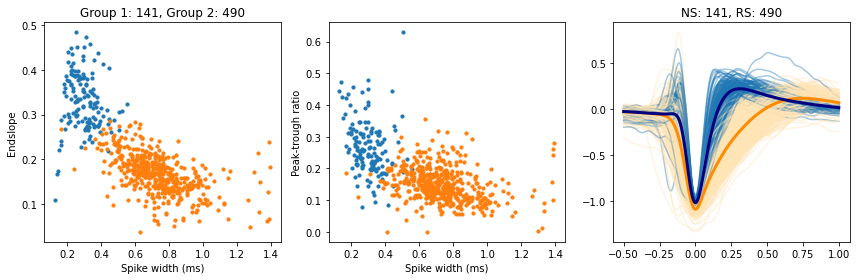

In [8]:
axes = plot_waveforn_cluster(wf_summary_df)


## Photo activated neurons

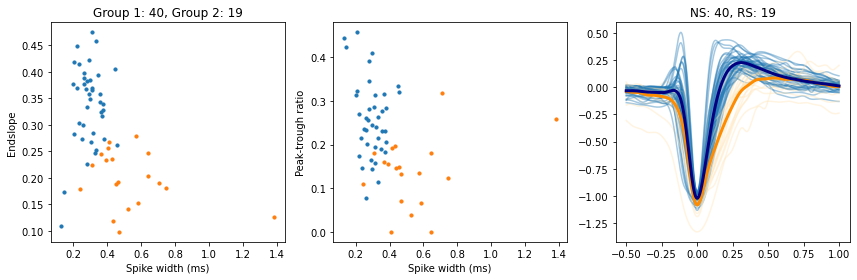

In [9]:
toplot = wf_summary_df.loc[wf_summary_df.phototag == 'a',:].dropna(axis=0)
axes = plot_waveforn_cluster(toplot)

## Photo suppresed neurons

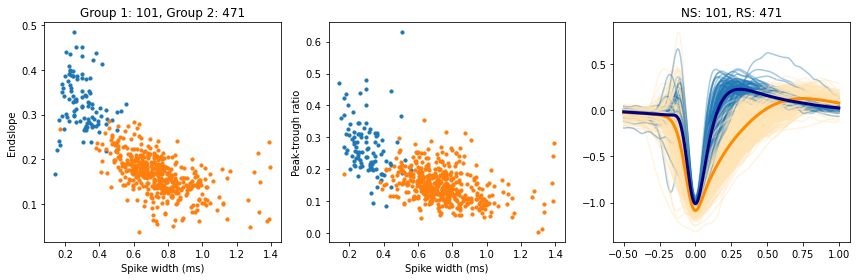

In [10]:
toplot = wf_summary_df.loc[wf_summary_df.phototag == 's', :].dropna(axis=0)
axes = plot_waveforn_cluster(toplot)